In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

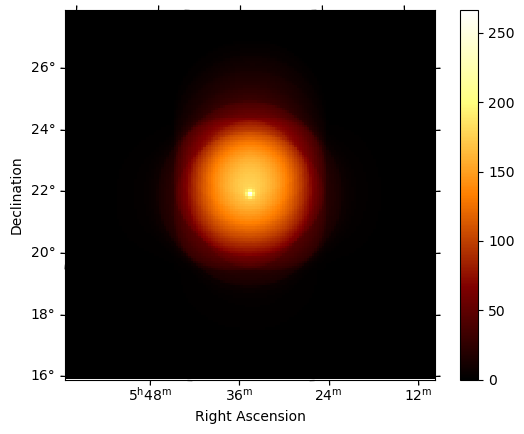

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

shift_neg = -0.085
tilt_neg = 1e-25 # energy independent

print(tilt_neg)
datasets = []
datasets_N = []
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        rnd = False)
dataset = sys_.create_dataset()
dataset.models[0].parameters['lon_0'].frozen = True
dataset.models[0].parameters['lat_0'].frozen = True
datasets.append(dataset)
    
dataset_N = sys_.create_dataset_N()
penalising_covmatrix = [[1/shift_neg**2, 0], [0 , 1/tilt_neg**2]]
penalising_invcovmatrix =  penalising_covmatrix
dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_N.models[0].parameters['lon_0'].frozen = True
dataset_N.models[0].parameters['lat_0'].frozen = True
datasets_N.append(dataset_N)

1e-25


In [5]:
%%time
fit = Fit(store_trace=False)
result = fit.run([datasets[0]])

CPU times: total: 3.84 s
Wall time: 3.86 s


In [6]:
%%time
fit_N = Fit(store_trace=False)
result_N = fit_N.run([datasets_N[0]])

CPU times: total: 39.5 s
Wall time: 39.5 s


# Stat Profiles

## Stat Profiles for BKG Norm

In [7]:
computing_norm = False
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [8]:
%%time
if computing_norm :
    parameter = datasets[0].models[1].parameters['norm']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile = fit.stat_profile([datasets[0]], parameter, reoptimize= True)
    stat_profile['scale_scan'] = stat_profile.pop(next(iter(stat_profile)) )    
    with open('data/5_scan_norm.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile), file)
else:
    with open('data/5_scan_norm.yaml') as file:
        stat_profile = yaml.load( file, Loader=yaml.FullLoader)   

CPU times: total: 41.2 s
Wall time: 41.2 s


In [9]:
%%time
if computing_norm :
    parameter = datasets_N[0].models[1].parameters['norm']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile_N = fit.stat_profile([datasets_N[0]], parameter, reoptimize = True)
    stat_profile_N['scale_scan'] = stat_profile_N.pop(next(iter(stat_profile_N)) )    
    with open('data/5_scan_norm_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N), file)
    for k in stat_profile_N:
        if "spectral" in k:
            key_name = "scale_scan"
            stat_profile_N[key_name] = stat_profile_N[k]      
else:
    with open('data/5_scan_norm_N.yaml') as file:
        stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)
    

CPU times: total: 9min 57s
Wall time: 9min 58s


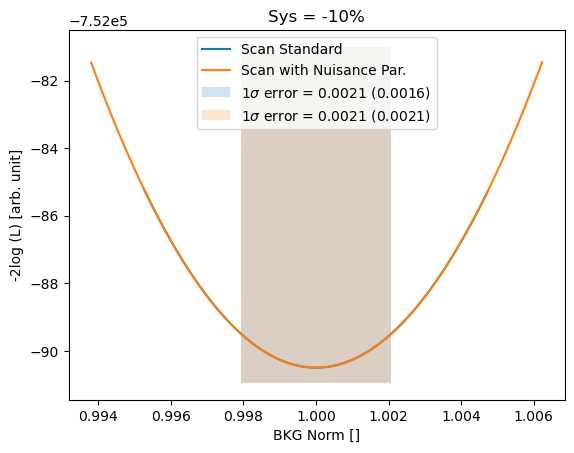

In [11]:
import upper_limit_18_02

fig = plt.figure()
ll_N = stat_profile_N.copy()
ul_N = upper_limit_18_02.upper_limit(ll_N,0,0)
L_N, x_N = ul_N.interpolate()
plt.plot(x_N, L_N(x_N),label ="Scan Standard")

ll = stat_profile.copy()
ul = upper_limit_18_02.upper_limit(ll,0,0)
L, x = ul.interpolate()
plt.plot(x, L(x),label ="Scan with Nuisance Par.")

norm_err_N = datasets_N[0].models.parameters['norm'].error
norm_err = datasets[0].models.parameters['norm'].error


min_, er, upp = ul_N.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err_N:.2})')
min_, er, upp = ul.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err:.2})')

plt.xlabel("BKG Norm []")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-4)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_norm.png")

## Stat Profiles for Source Signal

In [12]:
%%time
computing_amplitude = False

if computing_amplitude:
    sigma = 3
    parameter_a = datasets[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5_scan_amplitude.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: total: 45.9 s
Wall time: 46 s


In [14]:
%%time
computing_amplitude_N = False
if computing_amplitude_N:
    sigma = 3
    parameter_a = datasets_N[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5_scan_amplitude_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5_scan_amplitude_N.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: total: 20min 17s
Wall time: 20min 19s


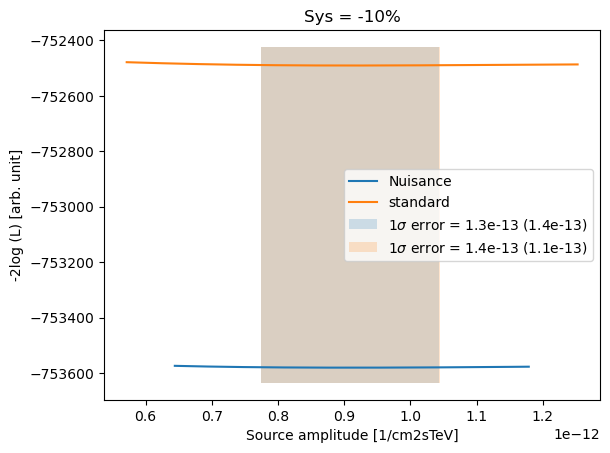

In [22]:
fig = plt.figure()
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "Standard")

amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error



min_, er, upp = ul_N_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({amplitude_err_N:.2})')
min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({amplitude_err:.2})')

plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_amplitude.png")

## Stat Profiles for Source Index

In [15]:
%%time
computing_index = True

if computing_index:
    sigma = 3
    parameter_i = datasets[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_index.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: total: 48.9 s
Wall time: 48.9 s


In [16]:
%%time
computing_index_N = True
if computing_index_N:
    sigma = 3
    parameter_i = datasets_N[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_N_i = fit.stat_profile([datasets_N[0]], parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5_scan_index_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5_scan_index_N.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: total: 18min 43s
Wall time: 18min 44s


An exception occurred


TypeError: 'float' object is not subscriptable

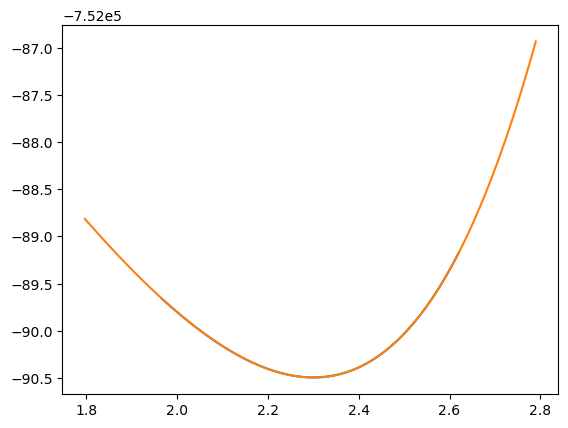

In [17]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "Standard")

index_err = datasets[0].models[0].parameters['index'].error
index_err_N = datasets_N[0].models[0].parameters['index'].error



min_, er, upp = ul_N_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err_N:.2})')
min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err:.2})')

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_index.png")

## Penalty Examples

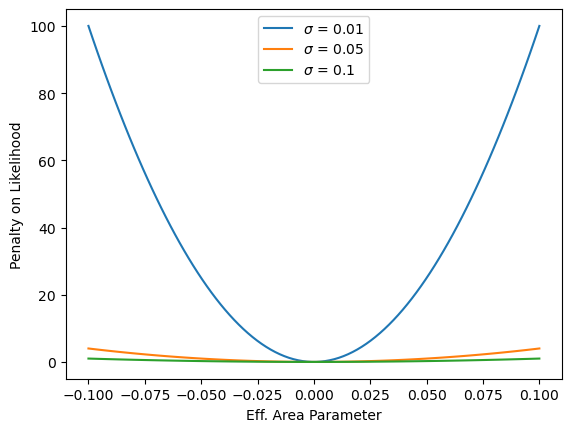

In [18]:
ps = [1e-2, 0.05, 0.1]
plot_values = np.linspace(-0.1, 0.1, 100)
for p in ps:
    plt.plot(plot_values, plot_values ** 2 / p ** 2, label = "$\sigma$ = "+ str(p)) 
plt.legend()

plt.ylabel('Penalty on Likelihood')    
plt.xlabel('Eff. Area Parameter')
fig  = plt.gcf()
fig.savefig('plots/5_gaussian_penalty_example.pdf')